# Read Parquet Files

This notebook reads and explores the parquet files produced by the HindiBabyNet pipeline:

| File | Stage | Description |
|------|-------|-------------|
| `recordings.parquet` | 01 Data Ingestion | Metadata for each raw WAV recording |
| `*_audio_manifest.parquet` | 02 Audio Preparation | Segment mapping from source recordings to combined audio |
| `*_vad.parquet` | 03 VAD | WebRTC voice-activity regions |
| `*_diarization.parquet` | 04 Diarization | Speaker turns from pyannote |
| `*_speech_segments.parquet` | 05 Intersection | VAD ∩ Diarization segments |
| `*_classified_segments.parquet` | 06 Classification | Per-segment speaker predictions |
| `*_main_female.parquet` | 06 Classification | Female stream segment offsets |
| `*_main_male.parquet` | 06 Classification | Male stream segment offsets |
| `*_child.parquet` | 06 Classification | Child stream segment offsets |
| `*_background.parquet` | 06 Classification | Background stream segment offsets |

In [11]:
%pwd

'/itf-fi-ml/home/arunps/Projects/HindiBabyNet'

In [12]:
import os
#os.chdir("..")
%pwd

'/itf-fi-ml/home/arunps/Projects/HindiBabyNet'

In [13]:
from pathlib import Path
import pandas as pd

ARTIFACTS_DIR = Path("artifacts/runs")
print(f"Artifacts root: {ARTIFACTS_DIR.resolve()}")
print(f"Available runs: {sorted(p.name for p in ARTIFACTS_DIR.iterdir())}")

Artifacts root: /itf-fi-ml/home/arunps/Projects/HindiBabyNet/artifacts/runs
Available runs: ['.gitkeep', '20260209_163255', '20260209_163812', '20260210_130337', '20260210_131458', '20260210_131852', '20260210_132648', '20260210_145617', '20260210_163159', '20260210_163202', '20260210_163227', '20260210_172217', '20260210_172220', '20260210_173908', '20260211_104943', '20260211_104949', '20260211_110614', '20260211_133515', '20260211_133518', '20260211_135201', '20260212_132214', '20260212_132222', '20260212_133925', '20260212_134445', '20260212_134452', '20260216_113050', '20260216_113617', '20260216_113924', '20260216_114131', '20260217_123413', '20260217_123417', '20260217_123437', '20260217_123503', '20260217_124715', '20260217_124716', '20260217_133307']


## 1. Select a run

Set `RUN_ID` to the timestamp folder you want to inspect, or leave as `"latest"` to auto-pick the most recent run.

In [14]:
RUN_ID = "latest"  # e.g. "20260212_134445" or "latest"

if RUN_ID == "latest":
    RUN_ID = sorted(p.name for p in ARTIFACTS_DIR.iterdir())[-1]

run_dir = ARTIFACTS_DIR / RUN_ID
print(f"Selected run: {run_dir}")
print(f"Stages: {[p.name for p in run_dir.iterdir()]}")

Selected run: artifacts/runs/20260217_133307
Stages: ['vad', 'diarization', 'intersection', 'speaker_classification', 'audio_preparation', 'data_ingestion']


## 2. Helper: discover & load parquets

In [15]:
def find_parquets(root: Path) -> list[Path]:
    """Recursively find all .parquet files under `root`."""
    return sorted(root.rglob("*.parquet"))


def load_parquets(root: Path) -> dict[str, pd.DataFrame]:
    """Load every parquet under `root` into a {stem: DataFrame} dict."""
    return {p.stem: pd.read_parquet(p) for p in find_parquets(root)}


# Show what's available in the selected run
parquet_files = find_parquets(run_dir)
for p in parquet_files:
    print(p.relative_to(ARTIFACTS_DIR))

20260217_133307/audio_preparation/ABAN141223_audio_manifest.parquet
20260217_133307/data_ingestion/recordings.parquet
20260217_133307/diarization/ABAN141223_diarization.parquet
20260217_133307/intersection/ABAN141223_speech_segments.parquet
20260217_133307/speaker_classification/ABAN141223_background.parquet
20260217_133307/speaker_classification/ABAN141223_child.parquet
20260217_133307/speaker_classification/ABAN141223_classified_segments.parquet
20260217_133307/speaker_classification/ABAN141223_main_female.parquet
20260217_133307/speaker_classification/ABAN141223_main_male.parquet
20260217_133307/vad/ABAN141223_vad.parquet


## 3. Recordings (`data_ingestion/recordings.parquet`)

One row per raw WAV file with duration, sample-rate, format, and file-size metadata.

In [16]:
recordings_path = next(
    (p for p in parquet_files if p.name == "recordings.parquet"), None
)

if recordings_path:
    recordings = pd.read_parquet(recordings_path)

    print(f"Loaded from: {recordings_path.relative_to(ARTIFACTS_DIR)}")
    print(f"Shape: {recordings.shape}")
    display(recordings.head())
    display(recordings.describe())
else:
    print("No recordings.parquet found in the selected run.")

Loaded from: 20260217_133307/data_ingestion/recordings.parquet
Shape: (111, 11)


,participant_id,session_date,recording_id,path,duration_sec,sample_rate,channels,frames,subtype,format,size_bytes
0,ABAN141223,20250216,1739683525,/scratch/users/arunps/hindibabynet/audio_raw/R...,17940.02,16000,1,287040320,PCM_16,WAV,574081152
1,ABAN141223,20250216,1739701628,/scratch/users/arunps/hindibabynet/audio_raw/R...,7331.10,16000,1,117297600,PCM_16,WAV,234595712
2,ADGA210923,20250216,1739685429,/scratch/users/arunps/hindibabynet/audio_raw/R...,17940.02,16000,1,287040320,PCM_16,WAV,574081152
3,ADGA210923,20250216,1739703674,/scratch/users/arunps/hindibabynet/audio_raw/R...,5878.40,16000,1,94054400,PCM_16,WAV,188109312
4,AHKV290824,20250323,1742709081,/scratch/users/arunps/hindibabynet/audio_raw/R...,17940.02,16000,1,287040320,PCM_16,WAV,574081152


,duration_sec,sample_rate,channels,frames,size_bytes
count,111.000000,111.0,111.0,1.110000e+02,1.110000e+02
mean,11211.920541,16000.0,1.0,1.793907e+08,3.587820e+08
std,6643.092994,0.0,0.0,1.062895e+08,2.125790e+08
min,1.040000,16000.0,1.0,1.664000e+04,3.379200e+04
25%,6025.720000,16000.0,1.0,9.641152e+07,1.928236e+08
50%,11543.340000,16000.0,1.0,1.846934e+08,3.693874e+08
75%,17940.020000,16000.0,1.0,2.870403e+08,5.740812e+08
max,17940.020000,16000.0,1.0,2.870403e+08,5.740812e+08


## 4. Audio Manifest (`audio_preparation/*_audio_manifest.parquet`)

Maps source recordings to their combined/processed audio files.

In [ ]:
manifest_files = sorted(run_dir.rglob("*_audio_manifest.parquet"))
print(f"Found {len(manifest_files)} audio manifest file(s) in run {RUN_ID}")

if manifest_files:
    manifests = pd.concat(
        [pd.read_parquet(f) for f in manifest_files],
        ignore_index=True,
    )
    print(f"Combined shape: {manifests.shape}")
    display(manifests.head())
    display(manifests.dtypes)

Found 231 audio manifest file(s)
Combined shape: (565, 11)


,source_index,source_path,source_recording_id,combined_start_sec,combined_end_sec,source_duration_sec,sample_rate,channels,participant_id,recording_id,combined_raw_path
0,0,/scratch/users/arunps/hindibabynet/audio_raw/R...,1739683525,0.00,17940.02,17940.02,16000,1,ABAN141223,ABAN141223,/scratch/users/arunps/hindibabynet/audio_proce...
1,1,/scratch/users/arunps/hindibabynet/audio_raw/R...,1739701628,17940.02,25271.12,7331.10,16000,1,ABAN141223,ABAN141223,/scratch/users/arunps/hindibabynet/audio_proce...
2,0,/scratch/users/arunps/hindibabynet/audio_raw/R...,1739685429,0.00,17940.02,17940.02,16000,1,ADGA210923,ADGA210923,/scratch/users/arunps/hindibabynet/audio_proce...
3,1,/scratch/users/arunps/hindibabynet/audio_raw/R...,1739703674,17940.02,23818.42,5878.40,16000,1,ADGA210923,ADGA210923,/scratch/users/arunps/hindibabynet/audio_proce...
4,0,/scratch/users/arunps/hindibabynet/audio_raw/R...,1739702694,0.00,7448.34,7448.34,16000,1,1739702694,1739702694,NaN


source_index             int64
source_path             object
source_recording_id     object
combined_start_sec     float64
combined_end_sec       float64
source_duration_sec    float64
sample_rate              int64
channels                 int64
participant_id          object
recording_id            object
combined_raw_path       object
dtype: object

## 5. Segments (`speaker_classification/*_segments.parquet`)

Per-segment speaker classification results with probabilities for adult-male, adult-female, child, and background.

In [ ]:
segment_files = sorted(run_dir.rglob("*_segments.parquet"))
print(f"Found {len(segment_files)} segment file(s) in run {RUN_ID}")

if segment_files:
    segments = pd.concat(
        [
            pd.read_parquet(f).assign(file=f.stem.replace("_segments", ""))
            for f in segment_files
        ],
        ignore_index=True,
    )
    print(f"Combined shape: {segments.shape}")
    display(segments.head())
    display(segments.describe())

Found 75 segment file(s)
Combined shape: (434369, 18)


,_merge_group,chunk_id,speaker_id_local,start_sec,end_sec,n_merged,duration_sec,n_windows,probs_adult_male,probs_adult_female,probs_child,probs_background,predicted_class,predicted_confidence,file,segment_id,vad_region_id,source_segment_ids
0,48.0,0,SPEAKER_02,0.132219,4.485969,3.0,4.353750,8.0,0.008513,0.142738,0.339449,0.509300,background,0.509300,ABAN141223,NaN,NaN,NaN
1,49.0,0,SPEAKER_02,5.498469,117.090000,15.0,111.591531,223.0,0.006136,0.213114,0.245390,0.535360,background,0.535360,ABAN141223,NaN,NaN,NaN
2,1.0,0,SPEAKER_00,16.652844,16.973469,1.0,0.320625,1.0,0.000498,0.006875,0.136892,0.855735,background,0.855735,ABAN141223,NaN,NaN,NaN
3,181.0,0,SPEAKER_03,85.620969,86.295969,1.0,0.675000,1.0,0.004964,0.608248,0.114383,0.272405,adult_female,0.608248,ABAN141223,NaN,NaN,NaN
4,182.0,0,SPEAKER_03,91.409094,92.084094,1.0,0.675000,1.0,0.002387,0.997238,0.000093,0.000282,adult_female,0.997238,ABAN141223,NaN,NaN,NaN


,_merge_group,chunk_id,start_sec,end_sec,n_merged,duration_sec,n_windows,probs_adult_male,probs_adult_female,probs_child,probs_background,predicted_confidence,segment_id,vad_region_id
count,421442.000000,434369.000000,434369.000000,434369.000000,427237.000000,434369.000000,427237.000000,427237.000000,427237.000000,4.272370e+05,427237.000000,427237.000000,7132.000000,7132.000000
mean,3495.380491,16.318464,14968.955820,14971.223697,1.385030,2.267878,4.214043,0.044792,0.197190,2.976879e-01,0.460330,0.714093,3565.500000,3153.728547
std,2711.062280,13.279924,11820.172222,11820.198417,1.056819,3.377641,6.723091,0.143520,0.288796,2.792289e-01,0.308901,0.180297,2058.975392,1939.914937
min,1.000000,0.000000,0.030969,0.334719,1.000000,0.200281,1.000000,0.000003,0.000004,3.350371e-07,0.000001,0.259652,0.000000,0.000000
25%,1444.000000,7.000000,6461.505344,6463.564094,1.000000,0.658125,1.000000,0.001082,0.004463,5.350280e-02,0.184968,0.560484,1782.750000,1693.000000
50%,2934.000000,14.000000,13010.020969,13012.231594,1.000000,1.282500,2.000000,0.004453,0.037051,2.163388e-01,0.442561,0.708497,3565.500000,3124.500000
75%,4877.000000,22.000000,20238.915344,20241.851594,1.000000,2.581875,5.000000,0.016303,0.290013,4.761762e-01,0.725074,0.878641,5348.250000,4295.250000
max,15700.000000,73.000000,65362.290344,65363.160000,55.000000,144.264375,288.000000,0.999972,0.999883,9.998043e-01,0.999885,0.999972,7131.000000,7132.000000


## 6. Quick Summary

In [10]:
if "segments" in dir():
    print("Speaker class distribution:")
    display(segments["predicted_class"].value_counts())

    print("\nMean confidence by class:")
    display(
        segments.groupby("predicted_class")["predicted_confidence"]
        .mean()
        .sort_values(ascending=False)
    )

    print(f"\nTotal segments duration: {segments['duration_sec'].sum():.1f}s")

Speaker class distribution:


predicted_class
background      213264
child           114751
adult_female     84652
adult_male       14570
Name: count, dtype: int64


Mean confidence by class:


predicted_class
adult_male      0.727896
background      0.725059
adult_female    0.718083
child           0.689015
Name: predicted_confidence, dtype: float64


Total segments duration: 985095.7s


## 7. Load a specific parquet by path

Use this cell to load any arbitrary parquet file.

In [ ]:
# Load any parquet from the selected run by name pattern
# Change the pattern below to match the file you want
PATTERN = "*_segments.parquet"  # e.g. "*_vad.parquet", "*_diarization.parquet", "*_speech_segments.parquet"

matches = sorted(run_dir.rglob(PATTERN))
print(f"Pattern '{PATTERN}' matched {len(matches)} file(s) in run {RUN_ID}:")
for m in matches:
    print(f"  {m.relative_to(ARTIFACTS_DIR)}")

if matches:
    df = pd.read_parquet(matches[0])
    print(f"\nLoaded: {matches[0].name}  |  Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    display(df.head(10))
    display(df.dtypes)

Shape: (4748, 14)
Columns: ['_merge_group', 'chunk_id', 'speaker_id_local', 'start_sec', 'end_sec', 'n_merged', 'duration_sec', 'n_windows', 'probs_adult_male', 'probs_adult_female', 'probs_child', 'probs_background', 'predicted_class', 'predicted_confidence']


,_merge_group,chunk_id,speaker_id_local,start_sec,end_sec,n_merged,duration_sec,n_windows,probs_adult_male,probs_adult_female,probs_child,probs_background,predicted_class,predicted_confidence
0,78,0,SPEAKER_02,4.064094,16.247844,4,12.183750,24,0.023625,0.211238,0.301810,0.463327,background,0.463327
1,44,0,SPEAKER_01,6.764094,7.810344,1,1.046250,2,0.002528,0.018193,0.110067,0.869211,background,0.869211
2,45,0,SPEAKER_01,8.350344,9.312219,1,0.961875,1,0.003216,0.021354,0.536365,0.439065,child,0.536365
3,46,0,SPEAKER_01,11.084094,11.421594,1,0.337500,1,0.319251,0.324147,0.161447,0.195155,adult_female,0.324147
4,79,0,SPEAKER_02,17.070000,17.884719,1,0.814719,1,0.059886,0.405806,0.104663,0.429645,background,0.429645
5,47,0,SPEAKER_01,17.631594,18.357219,1,0.725625,1,0.994274,0.005304,0.000169,0.000253,adult_male,0.994274
6,80,0,SPEAKER_02,18.357219,19.082844,1,0.725625,1,0.000180,0.003240,0.957550,0.039031,child,0.957550
7,81,0,SPEAKER_02,21.057219,21.462219,1,0.405000,1,0.021288,0.026380,0.074782,0.877550,background,0.877550
8,82,0,SPEAKER_02,22.500000,26.609094,1,4.109094,8,0.128447,0.134337,0.354535,0.382681,background,0.382681
9,48,0,SPEAKER_01,22.947219,23.234094,1,0.286875,1,0.000768,0.004759,0.957380,0.037094,child,0.957380


_merge_group              int64
chunk_id                  int64
speaker_id_local         object
start_sec               float64
end_sec                 float64
n_merged                  int64
duration_sec            float64
n_windows                 int64
probs_adult_male        float64
probs_adult_female      float64
probs_child             float64
probs_background        float64
predicted_class          object
predicted_confidence    float64
dtype: object

## 8. Segment Duration Distribution (Female & Male Streams)

Load the per-class stream parquets from the selected run and visualise how segment durations are distributed.
Set `PID` to the participant you want to inspect.

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# ── Config ──────────────────────────────────────────────
PID = "ABAN141223"      # participant id
# ────────────────────────────────────────────────────────

sc_dir = run_dir / "speaker_classification"

fem_pq = sc_dir / f"{PID}_main_female.parquet"
mal_pq = sc_dir / f"{PID}_main_male.parquet"

print(f"Run    : {RUN_ID}")
print(f"Female : {fem_pq}  exists={fem_pq.exists()}")
print(f"Male   : {mal_pq}  exists={mal_pq.exists()}")

fem_df = pd.read_parquet(fem_pq) if fem_pq.exists() else pd.DataFrame()
mal_df = pd.read_parquet(mal_pq) if mal_pq.exists() else pd.DataFrame()

print(f"\nFemale segments: {len(fem_df)}")
print(f"Male   segments: {len(mal_df)}")

Run    : 20260217_133307
Female : artifacts/runs/20260217_133307/speaker_classification/ABAN141223_main_female.parquet  exists=True
Male   : artifacts/runs/20260217_133307/speaker_classification/ABAN141223_main_male.parquet  exists=True

Female segments: 1868
Male   segments: 157


In [18]:
# ── Summary statistics ──────────────────────────────────
dur_col = "orig_duration_sec"  # duration in the original analysis WAV

for label, sdf in [("Female", fem_df), ("Male", mal_df)]:
    if sdf.empty:
        print(f"{label}: no segments")
        continue
    d = sdf[dur_col]
    print(f"\n{'='*50}")
    print(f"  {label} stream  ({len(sdf)} segments)")
    print(f"{'='*50}")
    print(f"  Total duration : {d.sum():.1f}s  ({d.sum()/3600:.2f}h)")
    print(f"  Mean           : {d.mean():.3f}s")
    print(f"  Median         : {d.median():.3f}s")
    print(f"  Std            : {d.std():.3f}s")
    print(f"  Min            : {d.min():.3f}s")
    print(f"  Max            : {d.max():.3f}s")
    print(f"  25th pctl      : {d.quantile(0.25):.3f}s")
    print(f"  75th pctl      : {d.quantile(0.75):.3f}s")
    print(f"  90th pctl      : {d.quantile(0.90):.3f}s")
    print(f"  95th pctl      : {d.quantile(0.95):.3f}s")
    print(f"  99th pctl      : {d.quantile(0.99):.3f}s")


  Female stream  (1868 segments)
  Total duration : 3328.4s  (0.92h)
  Mean           : 1.782s
  Median         : 1.310s
  Std            : 1.996s
  Min            : 0.001s
  Max            : 44.972s
  25th pctl      : 0.764s
  75th pctl      : 2.177s
  90th pctl      : 3.437s
  95th pctl      : 4.917s
  99th pctl      : 8.056s

  Male stream  (157 segments)
  Total duration : 180.1s  (0.05h)
  Mean           : 1.147s
  Median         : 1.032s
  Std            : 0.812s
  Min            : 0.017s
  Max            : 5.718s
  25th pctl      : 0.675s
  75th pctl      : 1.472s
  90th pctl      : 1.888s
  95th pctl      : 2.170s
  99th pctl      : 4.562s


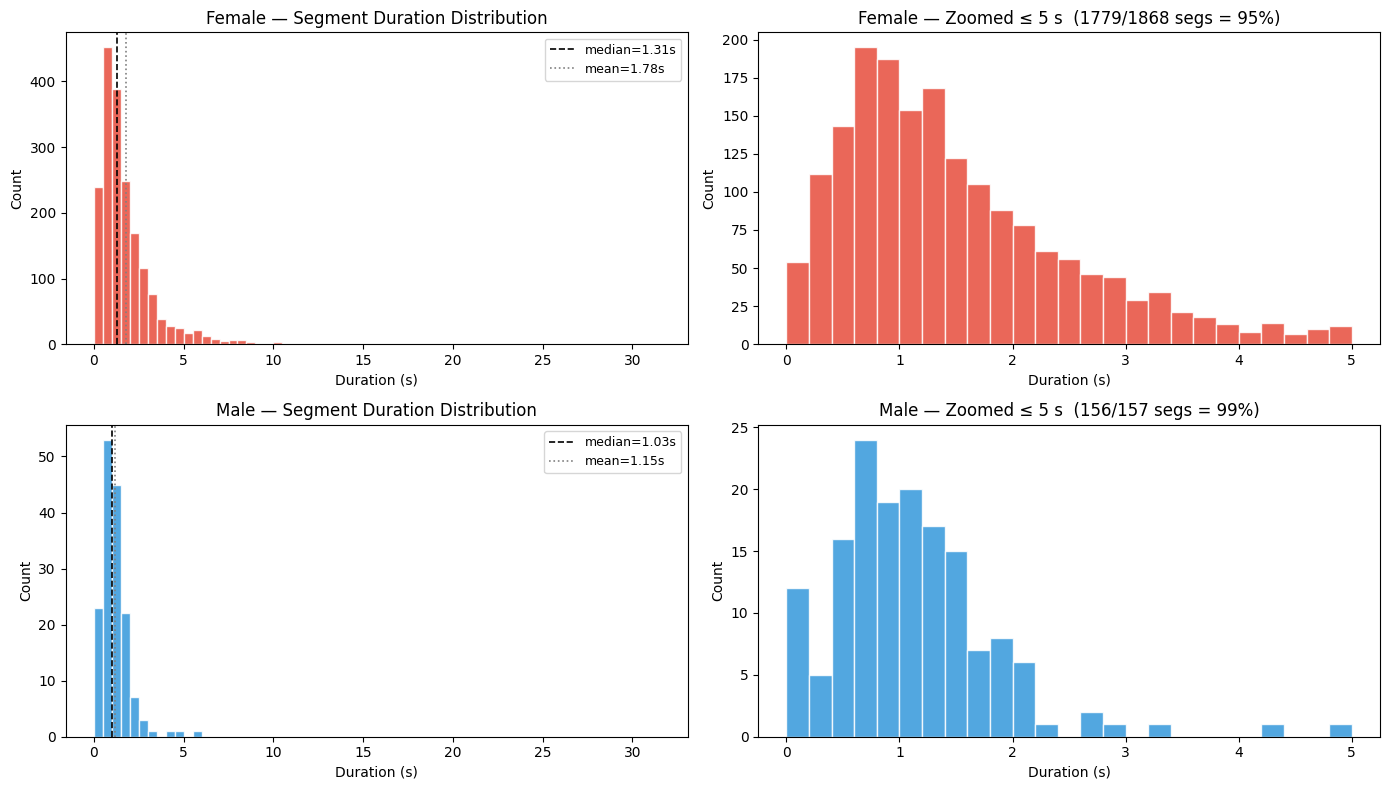

In [19]:
# ── Histograms: segment duration distribution ──────────
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
bins = np.arange(0, 32, 0.5)  # 0–30 s in 0.5 s bins

for idx, (label, sdf, color) in enumerate([
    ("Female", fem_df, "#e74c3c"),
    ("Male",   mal_df, "#3498db"),
]):
    if sdf.empty:
        continue
    d = sdf[dur_col]

    # Left: full histogram
    ax = axes[idx, 0]
    ax.hist(d, bins=bins, color=color, edgecolor="white", alpha=0.85)
    ax.set_title(f"{label} — Segment Duration Distribution")
    ax.set_xlabel("Duration (s)")
    ax.set_ylabel("Count")
    ax.axvline(d.median(), color="black", ls="--", lw=1.2, label=f"median={d.median():.2f}s")
    ax.axvline(d.mean(), color="gray", ls=":", lw=1.2, label=f"mean={d.mean():.2f}s")
    ax.legend(fontsize=9)

    # Right: zoomed ≤ 5 s
    ax2 = axes[idx, 1]
    short = d[d <= 5]
    ax2.hist(short, bins=np.arange(0, 5.1, 0.2), color=color, edgecolor="white", alpha=0.85)
    ax2.set_title(f"{label} — Zoomed ≤ 5 s  ({len(short)}/{len(d)} segs = {100*len(short)/len(d):.0f}%)")
    ax2.set_xlabel("Duration (s)")
    ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()

In [20]:
# ── Duration buckets: how many short vs long segments ──
thresholds = [0.5, 1, 2, 3, 5, 10, 20, 30]

for label, sdf in [("Female", fem_df), ("Male", mal_df)]:
    if sdf.empty:
        continue
    d = sdf[dur_col]
    n = len(d)
    print(f"\n{'='*55}")
    print(f"  {label} — Segment count by duration bucket  (n={n})")
    print(f"{'='*55}")
    print(f"  {'Bucket':<18} {'Count':>7} {'%':>7}  {'Cumul %':>8}")
    print(f"  {'-'*42}")

    cum = 0
    prev = 0.0
    for t in thresholds:
        cnt = int(((d >= prev) & (d < t)).sum())
        cum += cnt
        print(f"  {prev:>5.1f}s – {t:>5.1f}s   {cnt:>7}  {100*cnt/n:>6.1f}%  {100*cum/n:>7.1f}%")
        prev = t
    cnt = int((d >= prev).sum())
    cum += cnt
    print(f"  {prev:>5.1f}s +          {cnt:>7}  {100*cnt/n:>6.1f}%  {100*cum/n:>7.1f}%")


  Female — Segment count by duration bucket  (n=1868)
  Bucket               Count       %   Cumul %
  ------------------------------------------
    0.0s –   0.5s       239    12.8%     12.8%
    0.5s –   1.0s       452    24.2%     37.0%
    1.0s –   2.0s       637    34.1%     71.1%
    2.0s –   3.0s       285    15.3%     86.3%
    3.0s –   5.0s       166     8.9%     95.2%
    5.0s –  10.0s        80     4.3%     99.5%
   10.0s –  20.0s         5     0.3%     99.8%
   20.0s –  30.0s         3     0.2%     99.9%
   30.0s +                1     0.1%    100.0%

  Male — Segment count by duration bucket  (n=157)
  Bucket               Count       %   Cumul %
  ------------------------------------------
    0.0s –   0.5s        23    14.6%     14.6%
    0.5s –   1.0s        53    33.8%     48.4%
    1.0s –   2.0s        67    42.7%     91.1%
    2.0s –   3.0s        10     6.4%     97.5%
    3.0s –   5.0s         3     1.9%     99.4%
    5.0s –  10.0s         1     0.6%    100.0%
   1

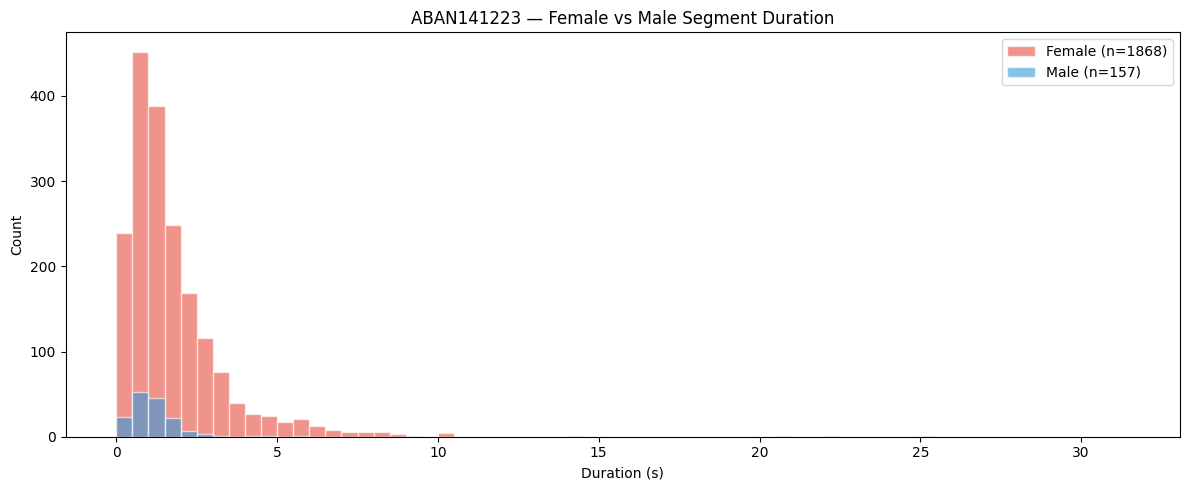

In [21]:
# ── Side-by-side comparison: Female vs Male ────────────
fig, ax = plt.subplots(figsize=(12, 5))

if not fem_df.empty and not mal_df.empty:
    ax.hist(fem_df[dur_col], bins=bins, alpha=0.6, color="#e74c3c", label=f"Female (n={len(fem_df)})", edgecolor="white")
    ax.hist(mal_df[dur_col], bins=bins, alpha=0.6, color="#3498db", label=f"Male (n={len(mal_df)})", edgecolor="white")
    ax.set_title(f"{PID} — Female vs Male Segment Duration")
    ax.set_xlabel("Duration (s)")
    ax.set_ylabel("Count")
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Need both female and male data for comparison.")

In [22]:
# ── Preview: first few rows of the stream parquets ─────
print("Female stream parquet:")
display(fem_df.head(10))

print("\nMale stream parquet:")
display(mal_df.head(10))

Female stream parquet:


,stream_segment_id,stream_start_sec,stream_end_sec,stream_duration_sec,orig_start_sec,orig_end_sec,orig_duration_sec,predicted_class
0,0,0.000000,0.644031,0.644031,85.651938,86.295969,0.644031,adult_female
1,1,0.000000,0.675000,0.675000,91.409094,92.084094,0.675000,adult_female
2,2,0.000000,1.029375,1.029375,93.923469,94.952844,1.029375,adult_female
3,3,0.000000,0.371250,0.371250,96.994719,97.365969,0.371250,adult_female
4,4,0.000000,3.104125,3.104125,101.940000,105.044094,3.104094,adult_female
5,5,6.579375,7.095031,0.515656,137.333438,137.849094,0.515656,adult_female
6,6,6.579375,7.904969,1.325594,142.624719,143.950312,1.325594,adult_female
7,7,8.720625,9.429375,0.708750,219.675969,220.384719,0.708750,adult_female
8,8,8.720625,9.524125,0.803500,243.780000,244.583469,0.803469,adult_female
9,9,8.720625,10.323750,1.603125,300.439719,302.042844,1.603125,adult_female



Male stream parquet:


,stream_segment_id,stream_start_sec,stream_end_sec,stream_duration_sec,orig_start_sec,orig_end_sec,orig_duration_sec,predicted_class
0,0,0.000000,0.540000,0.540000,755.707563,756.247563,0.540000,adult_male
1,1,0.690000,0.773469,0.083469,2066.433469,2066.516938,0.083469,adult_male
2,2,0.924375,1.751250,0.826875,2066.618188,2067.445062,0.826875,adult_male
3,3,1.901250,3.352500,1.451250,5439.931938,5441.383188,1.451250,adult_male
4,4,3.502500,4.332219,0.829719,5442.360000,5443.189694,0.829694,adult_male
5,5,4.496250,6.622500,2.126250,5457.734094,5459.860344,2.126250,adult_male
6,6,6.840000,7.869375,1.029375,5491.101562,5492.130938,1.029375,adult_male
7,7,8.019375,9.513781,1.494406,5523.284062,5524.778469,1.494406,adult_male
8,8,8.019375,9.277469,1.258094,5526.803469,5528.061563,1.258094,adult_male
9,9,11.071875,11.257500,0.185625,5528.129063,5528.314688,0.185625,adult_male
